Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.


[05:23:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



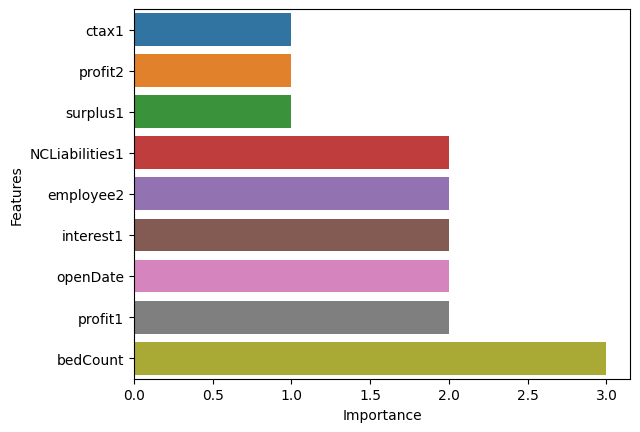

     inst_id       XGB       GBM   RF       ens  OC
1          5  0.655411  0.443177  0.8  0.632863   0
2          6  0.409096  0.666447  0.6  0.558514   0
13        30  0.409096  0.230173  0.8  0.479756   0
22        64  0.409096  0.936367  0.1  0.481821   0
78       229  0.409096  0.539125  0.6  0.516074   0
84       258  0.409096  0.442562  0.6  0.483886   0
88       293  0.409096  0.724379  0.7  0.611158   0
99       341  0.409096  0.278068  0.4  0.362388   0
120      413  0.409096  0.278068  0.4  0.362388   0
122      424  0.409096  0.312302  0.3  0.340466   0
123      425  0.409096  0.580902  0.7  0.563333   0
124      429  0.409096  0.536108  0.7  0.548401   0
126      431  0.409096  0.536108  0.6  0.515068   0


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 18 19:03:22 2018

@author: BTHANISH
"""

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import shap
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt


#Reading the train and test files
train_prod_df = pd.read_csv('data/train.csv')
test_prod_df = pd.read_csv('data/test.csv')

#Removing the comma in the employee1 and 2 columns in the test dataset and replace it with empty space and convert it to float format.
test_prod_df.employee1 = test_prod_df.employee1.astype('str').str.replace(",", "").astype('float')
test_prod_df.employee2 = test_prod_df.employee2.astype('str').str.replace(",", "").astype('float')

#Converting the employee1 and 2 column as float in the train set as done for the test dataset
train_prod_df.employee1 = train_prod_df.employee1.astype('float')
train_prod_df.employee2 = train_prod_df.employee2.astype('float')
train_prod_df.OC= train_prod_df.OC.astype('str').str.replace(" ","")

#Combining the train and test dataset
train_test_prod = train_prod_df.append(test_prod_df)

#Get the object and numeric columns seperately 
factor_columns = train_test_prod.select_dtypes(include = ['object']).columns
numeric_columns = train_test_prod.columns.difference(factor_columns)

#After analysis realized that the bed counts of these two hospitals may have had wrong entries.
#Filling up the empty instkind and bedCount for hospital id 430 and 413
train_test_prod.loc[train_test_prod.inst_id == 430, ['instkind']] = 'dental_clinic'
train_test_prod.loc[train_test_prod.inst_id == 430, ['bedCount']] = 0
train_test_prod.loc[train_test_prod.inst_id == 413, ['bedCount']] = -999

#Fill the empty values in the object columns as "Not sure"
train_test_prod[factor_columns] = train_test_prod[factor_columns].fillna('Not_sure')

#Fill all the empty values in the numeric columns as -999
train_test_prod[numeric_columns] = train_test_prod[numeric_columns].fillna(-999)

#Convert all the object columns to numeric since the ML algorithms don't accept object features directly 
fac_le = LabelEncoder()
train_test_prod[factor_columns] = train_test_prod.loc[:,factor_columns].apply(lambda x : fac_le.fit_transform(x))

#Splitting back data to train prod and test prod
train_prod = train_test_prod.loc[train_test_prod.OC != 0,]
test_prod = train_test_prod.loc[train_test_prod.OC == 0,]
train_prod['OC'] = train_prod['OC'] - 1

#Obtain the submission ID to create the submission file later
sub_id = test_prod.inst_id

#Get the dependent and independent column
dep = 'OC'
indep = train_prod.columns.difference([dep])


train_prod_X = train_prod[indep]
train_prod_Y = train_prod[dep]
test_prod_X = test_prod[indep]

############################################################################
############ Random Forest
############################################################################
estimators = 10
np.random.seed(100)
RF_prod = RandomForestClassifier(n_estimators = estimators)
RF_prod_model = RF_prod.fit(train_prod_X, train_prod_Y)
RF_prod_prediction = RF_prod.predict_proba(test_prod_X)[:,1]

sub_RF = pd.DataFrame({'inst_id' : sub_id , 'OC' : RF_prod_prediction })
sub_RF = sub_RF[['inst_id', 'OC']]
############################################################################
############ GBM
############################################################################
estimators = 10
np.random.seed(100)
GBM_prod = GradientBoostingClassifier(n_estimators = estimators)
GBM_prod_model = GBM_prod.fit(train_prod_X, train_prod_Y)
GBM_prod_prediction = GBM_prod.predict_proba(test_prod_X)[:,1]

sub_GBM = pd.DataFrame({'inst_id' : sub_id , 'OC' : GBM_prod_prediction })
sub_GBM = sub_GBM[['inst_id', 'OC']]
############################################################################
############ XGBOOST
############################################################################
dtrain_prod = xgb.DMatrix(data = train_prod_X, label = train_prod_Y)
dtest_prod = xgb.DMatrix(data = test_prod_X)

#Custom error function for the XGB model
from sklearn.metrics import f1_score
import numpy as np

def best_threshold_f1(preds, labels):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(labels, (preds > thr).astype('float')) for thr in thresholds]
    return thresholds[np.argmax(f1_scores)]

def eval_error(preds, dtrain):
    labels = dtrain.get_label()
    preds = (preds > 0.5).astype('float')
    return "f1_score", f1_score(labels, preds)
    

param = {'objective' : 'binary:logistic',
         'max_depth' : 6,
         'eta': 0.3,
         'colsample_bytree' : 1,
         'subsample' : 1,
         'silent' : 0
         }

nrounds = 2
np.random.seed(100)
xgb_model = xgb.train(param, 
                      dtrain_prod, 
                      num_boost_round = nrounds ,
                      feval = eval_error,
                      #maximize = True,
                      #early_stopping_rounds = 10,
                      )

XGB_prediction = xgb_model.predict(dtest_prod)

sub_XGB= pd.DataFrame({'inst_id' : sub_id , 'OC' : XGB_prediction })
sub_XGB= sub_XGB[['inst_id', 'OC']]
  
#PLotting the feature importance
xgb_Imp = pd.DataFrame({'Features' : list(xgb_model.get_score().keys()), 
                        'Importance' : list(xgb_model.get_score().values())}).sort_values(['Importance'])
plt.figure()
sns.barplot(x=xgb_Imp.Importance, y=xgb_Imp.Features)
plt.show()
############################################################################
#Ensembling the three models
############################################################################

# #Forming the ensemble dataset of the 3 models
ensemble = pd.DataFrame()
ensemble['inst_id'] = sub_XGB['inst_id']
ensemble['XGB'] = sub_XGB['OC']
ensemble['GBM'] = sub_GBM['OC']
ensemble['RF'] = sub_RF['OC']

# 훈련 데이터에 대한 예측값 얻기
RF_train_prediction = RF_prod.predict_proba(train_prod_X)[:, 1]
GBM_train_prediction = GBM_prod.predict_proba(train_prod_X)[:, 1]
XGB_train_prediction = xgb_model.predict(dtrain_prod)

# 훈련 데이터에 대한 앙상블 예측값 생성
ensemble_train = pd.DataFrame({
    'XGB': XGB_train_prediction,
    'GBM': GBM_train_prediction,
    'RF': RF_train_prediction
})
ensemble_train['ens'] = (ensemble_train['XGB'] + ensemble_train['GBM'] + ensemble_train['RF']) / 3

# 최적의 임계값 찾기
best_thr_ensemble = best_threshold_f1(ensemble_train['ens'], train_prod_Y)

# 테스트 데이터에 대한 앙상블 예측값 생성
ensemble = pd.DataFrame({
    'inst_id': sub_XGB['inst_id'],
    'XGB': sub_XGB['OC'],
    'GBM': sub_GBM['OC'],
    'RF': sub_RF['OC']
})
ensemble['ens'] = (ensemble['XGB'] + ensemble['GBM'] + ensemble['RF']) / 3

# 최적의 임계값을 테스트 데이터에 대한 앙상블 예측값에 적용
ensemble['OC'] = (ensemble['ens'] > best_thr_ensemble).astype('int')

# 출력하여 확인
print(ensemble.loc[ensemble['OC'] == 0, ])

ensemble = ensemble[['inst_id', 'OC']]

# # Taking the average of all 3 models
# ensemble['ens'] = (ensemble['XGB'] + ensemble['GBM'] + ensemble['RF'])/3
# # 앙상블 예측값에 대한 최적의 threshold 찾기
# best_thr_ensemble = best_threshold_f1(ensemble['ens'], train_prod_Y)  # train_prod_Y를 실제 라벨 값으로 사용

# # 최적의 threshold를 사용하여 앙상블 예측값을 이진 분류로 변환
# ensemble['OC'] = (ensemble['ens'] > best_thr_ensemble).astype('int')

# # 출력하여 확인
# print(ensemble.loc[ensemble['OC'] == 0, ])

# ensemble = ensemble.loc[:, ['inst_id', 'OC']]

ensemble.to_csv('ens.csv', index = False)


In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import optuna

def read_and_process_data():
    """Reads the data, processes it and returns the combined dataframe."""
    train_prod_df = pd.read_csv('data/train.csv')
    test_prod_df = pd.read_csv('data/test.csv')

    process_employee_data(test_prod_df)
    process_employee_data(train_prod_df)
    train_prod_df.OC = train_prod_df.OC.astype('str').str.replace(" ", "")

    return train_prod_df.append(test_prod_df)

def process_employee_data(df):
    """Processes the employee columns to convert them into float type."""
    df.employee1 = df.employee1.astype('str').str.replace(",", "").astype('float')
    df.employee2 = df.employee2.astype('str').str.replace(",", "").astype('float')

def fill_missing_values(df):
    """Fills the missing values in the dataframe."""
    df.loc[df.inst_id == 430, ['instkind']] = 'dental_clinic'
    df.loc[df.inst_id == 430, ['bedCount']] = 0
    df.loc[df.inst_id == 413, ['bedCount']] = -999

    factor_columns = df.select_dtypes(include=['object']).columns
    numeric_columns = df.columns.difference(factor_columns)
    df[factor_columns] = df[factor_columns].fillna('Not_sure')
    df[numeric_columns] = df[numeric_columns].fillna(-999)

def label_encode(df, factor_columns):
    """Encodes the categorical columns using Label Encoder."""
    fac_le = LabelEncoder()
    df[factor_columns] = df.loc[:, factor_columns].apply(lambda x: fac_le.fit_transform(x))

def split_train_test(df):
    """Splits the data into training and testing datasets."""
    train_data = df.loc[df.OC != 0, ]
    test_data = df.loc[df.OC == 0, ]
    train_data['OC'] = train_data['OC'] - 1

    return train_data, test_data

def objective_for_rf(trial, train_X, train_Y):
    """Objective function for tuning Random Forest using Optuna."""
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 16)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                   max_features=max_features)
    return np.mean(cross_val_score(model, train_X, train_Y, cv=3, scoring='f1'))

def objective_for_gbm(trial, train_X, train_Y):
    """Objective function for tuning Gradient Boosting using Optuna."""
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 16)

    model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                       learning_rate=learning_rate, subsample=subsample, 
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    return np.mean(cross_val_score(model, train_X, train_Y, cv=3, scoring='f1'))

def objective_for_xgb(trial, train_X, train_Y):
    """Objective function for tuning XGBoost using Optuna."""
    
    dtrain = xgb.DMatrix(train_X, label=train_Y)
    
    param = {
        'silent': 1,
        'objective': 'binary:logistic',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        param['n_estimators'] = trial.suggest_int('n_estimators', 50, 300)
        param['learning_rate'] = trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
        
    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtrain)
    
    pred_labels = np.rint(preds)
    return f1_score(train_Y, pred_labels)

def find_best_threshold(probs, y_true):
    """Find the best threshold to maximize F1 Score based on given probabilities."""
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(0, 1, 200): # 여러 임계값들을 테스트
        preds = (probs >= threshold).astype(int)
        f1 = f1_score(y_true, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

def main():
    """Main function that prepares data, optimizes the models, and creates the submission file."""
    train_test_prod = read_and_process_data()
    fill_missing_values(train_test_prod)

    factor_columns = train_test_prod.select_dtypes(include=['object']).columns
    label_encode(train_test_prod, factor_columns)

    train_prod, test_prod = split_train_test(train_test_prod)
    sub_id = test_prod.inst_id

    indep = train_prod.columns.difference(['OC'])
    train_prod_X = train_prod[indep]
    train_prod_Y = train_prod['OC']
    test_prod_X = test_prod[indep]

    # RandomForest Hyperparameter Tuning with Optuna
    study_rf = optuna.create_study(direction='maximize')
    study_rf.optimize(lambda trial: objective_for_rf(trial, train_prod_X, train_prod_Y), n_trials=30)
    best_rf_params = study_rf.best_params
    rf_best = RandomForestClassifier(**best_rf_params)
    rf_best.fit(train_prod_X, train_prod_Y)
    RF_predictions = rf_best.predict_proba(test_prod_X)[:, 1]

    # GradientBoosting Hyperparameter Tuning with Optuna
    study_gbm = optuna.create_study(direction='maximize')
    study_gbm.optimize(lambda trial: objective_for_gbm(trial, train_prod_X, train_prod_Y), n_trials=30)
    best_gbm_params = study_gbm.best_params
    gbm_best = GradientBoostingClassifier(**best_gbm_params)
    gbm_best.fit(train_prod_X, train_prod_Y)
    GBM_predictions = gbm_best.predict_proba(test_prod_X)[:, 1]
    
    # XGBoost Hyperparameter Tuning with Optuna
    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(lambda trial: objective_for_xgb(trial, train_prod_X, train_prod_Y), n_trials=30)
    best_xgb_params = study_xgb.best_params
    dtrain = xgb.DMatrix(train_prod_X, label=train_prod_Y)
    dtest = xgb.DMatrix(test_prod_X)
    xgb_best = xgb.train(best_xgb_params, dtrain)
    XGB_predictions = xgb_best.predict(dtest)

    # Ensemble of the models
    ensemble = pd.DataFrame({
        'inst_id': sub_id,
        'RF': RF_predictions,
        'GBM': GBM_predictions,
        'XGB': XGB_predictions
    })

    ensemble['ens'] = ensemble[['RF', 'GBM', 'XGB']].mean(axis=1)

    # Find the best threshold on ensemble probabilities
    best_threshold = find_best_threshold(ensemble['ens'], train_prod_Y)

    # Apply threshold to the ensemble predictions
    ensemble['OC'] = (ensemble['ens'] >= best_threshold).astype(int)

    submission = pd.DataFrame({
        'inst_id': ensemble['inst_id'],
        'OC': ensemble['OC']
    })
    submission.to_csv('submission.csv', index=False)
    
main()


/tmp/ipykernel_640211/1028909028.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return train_prod_df.append(test_prod_df)
/tmp/ipykernel_640211/1028909028.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['OC'] = train_data['OC'] - 1
[I 2023-08-24 09:47:20,573] A new study created in memory with name: no-name-0b6ee4aa-fcce-4ba1-9d25-a7fb743b3a94
/home/hjjung113/anaconda3/envs/hospital/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also t

NameError: name 'xgb' is not defined